# 02 - Kanton Zürich Wärmenutzungsatlas - Erdwärmezonen
### Author: Daniel Herrera-Russert
#### February 03, 2025

In [1]:
# !pip install geopandas owslib requests pyproj fiona

In [1]:
import pandas as pd
import numpy as np
import os

from owslib.wfs import WebFeatureService
import geopandas as gpd
import requests
from io import BytesIO
import fiona
from shapely.geometry import Point
from shapely.ops import unary_union
from geopandas import overlay

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyproj
from pyproj import Transformer # for converting coordinates

# Set the default renderer for JupyterLab
pio.renderers.default = 'iframe'

## 1. Loading the datasets

As part of the data obtained from the [Wärmenutzungsatlas](https://maps.zh.ch/s/yfueq6wo) of Kanton Zürich, we proceed with the extraction of the geographical dataset related to ground heat usage. Additional details can be found in the various datasets' [metadata](https://www.geolion.zh.ch/geodatensatz/show?gdsid=316).  

For this chapter, two datasets will be loaded and analyzed, both assessing the suitability of land for geothermal heat extraction. The first dataset delineates zoning based on the protection status of underground water reservoirs. The second dataset applies a more restrictive classification, identifying areas where geothermal probes are either prohibited or subject to limitations due to geological constraints.

The data is retrieved from the GIS portal via WFS service, in order to obtain the separate layers preserving the geographic data qualities. Alternatively, it could be downloaded manually directly from the GIS download section in a variety of formats for different purposes.

### 1.1. Thermal Usage Zones

Following is the extraction and exploration of the dataset,corresponding to the layer containing the ground heat usage zones based on groundwater protection.

In [3]:
# Define the WFS endpoint
WFS_URL = "https://maps.zh.ch/wfs/AwelGSWaermewwwZHWFS"

# Connect to the WFS service
wfs = WebFeatureService(WFS_URL, version="2.0.0")

# List available layers
print("Available layers:")
for layer in list(wfs.contents):
    print(layer)

Available layers:
ms:waermenutzung-zone-a
ms:waermenutzung-zone-b
ms:waermenutzung-zone-c
ms:waermenutzung-zone-d
ms:waermenutzung-zone-e
ms:waermenutzung-zone-f
ms:erdwaermesonden-auflagen
ms:tunnels-und-stollen
ms:erdwaermesonden
ms:sonden
ms:sammelschacht
ms:grundwasserpiezometer
ms:erdregister
ms:quellfassung-waermenutzung
ms:grundwasserfassung-waermenutzung
ms:quellfassung-ohne-waermenutzung
ms:grundwasserfassung-ohne-waermenutzung


In [4]:
# Define the list of layers to download the first dataset
layers = [
    "ms:waermenutzung-zone-a",
    "ms:waermenutzung-zone-b",
    "ms:waermenutzung-zone-c",
    "ms:waermenutzung-zone-d",
    "ms:waermenutzung-zone-e",
    "ms:waermenutzung-zone-f",
]

# Define expected CRS (EPSG:2056 - LV95)
expected_crs = "EPSG:2056"

# Define output file
output_geojson = "data/raw/zh_waermenutzung_zonen.geojson"

# Create an empty list to store GeoDataFrames
gdfs = []

# Loop through layers and process each one
for layer in layers:
    print(f"Downloading {layer}...")
    
    # Request data in GML format
    response = wfs.getfeature(typename=layer, outputFormat="GML2")
    
    # Read the response as a GeoDataFrame
    gdf = gpd.read_file(BytesIO(response.read()))
    
    # Check and set CRS if missing
    if gdf.crs is None:
        gdf.set_crs(expected_crs, inplace=True)
    
    # Add a new column for the zone classification based on the layer name
    gdf["ZONEN"] = layer.replace("ms:waermenutzung-zone-", "").upper()
    
    # Append the processed GeoDataFrame to the list
    gdfs.append(gdf)

# Concatenate all layers into a single GeoDataFrame
merged_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))

# Save the combined dataset as a GeoJSON file
merged_gdf.to_file(output_geojson, driver="GeoJSON")

print(f"All layers saved into '{output_geojson}' with CRS {expected_crs}")

All layers saved into 'data/raw/zh_waermenutzung_zonen.geojson' with CRS EPSG:2056


---

### 1.2. Geothermal Probe Restrictions (Erdwärmesonden Auflagen)

The **Auflagen** layer is extracted making use of the same WFS call.

In [5]:
# Define the restriction layer
restrictions_layer = "ms:erdwaermesonden-auflagen"

# Define output file
output_restrictions_geojson = "data/raw/zh_erdwaermesonden_auflagen.geojson"

print(f"Downloading {restrictions_layer}...")
response = wfs.getfeature(typename=restrictions_layer, outputFormat="GML2")
restrictions_gdf = gpd.read_file(BytesIO(response.read()))

# Check and set CRS if missing
if restrictions_gdf.crs is None:
    restrictions_gdf.set_crs(expected_crs, inplace=True)

# Save the dataset
restrictions_gdf.to_file(output_restrictions_geojson, driver="GeoJSON")

print(f"Restrictions saved as '{output_restrictions_geojson}' with CRS {expected_crs}")

Restrictions saved as 'data/raw/zh_erdwaermesonden_auflagen.geojson' with CRS EPSG:2056


---

## 2. Structure of the Datasets

### 2.1. Thermal Usage Zones
The `ZONEN` attribute categorizes areas based on **groundwater conditions** and their suitability for geothermal energy extraction:

- **B**: Gravel-based groundwater reservoirs, suitable for drinking water extraction.
- **B_Sperr**: Zone B with a restriction on geothermal probes.
- **C**: Gravel-based groundwater reservoirs, unsuitable for drinking water extraction (high-yield aquifer).
- **C_Sperr**: Zone C with a restriction on geothermal probes.
- **D**: Gravel-based groundwater reservoirs, unsuitable for drinking water extraction (low-yield aquifer).
- **D_Sperr**: Zone D with a restriction on geothermal probes.
- **E**: Spring water areas, suitable for drinking water extraction.
- **E_Sperr**: Zone E with a restriction on geothermal probes.
- **F**: Areas outside of usable groundwater reservoirs.
- **F_Sperr**: Zone F with a restriction on geothermal probes.
- **G**: Protection perimeter around drinking water intakes in the lower groundwater level.

This classification helps in **decision-making for geothermal energy projects**, ensuring compliance with **groundwater protection regulations** and identifying suitable locations for **geothermal probe installations**.

The following table from the legend of the [Wärmenutzungsatlas](https://maps.zh.ch/s/yfueq6wo) outlines the **permissibility of different geothermal energy systems** based on **groundwater conditions** and **water protection zones**. The classification determines whether **geothermal probes (Erdwärmesonden), energy piles, and groundwater-based heating systems** are allowed or restricted.

| **Groundwater Category**                                     | **Protection Zone** | **Zone** | **Geothermal Probes** | **Thermoactive Elements** | **Energy Registers (Fluid-Based)** | **Energy Registers (Air-Based)** | **Groundwater Heating** |
|-------------------------------------------------------------|--------------------|---------|---------------------|---------------------------|----------------------------------|----------------------------------|-------------------------|
| Gravel groundwater, suitable for drinking water extraction | S                  | A       | **Not Allowed (-)**  | **Not Allowed (-a)**      | **Not Allowed (-a)**            | **Not Allowed (-a)**            | **Not Allowed (-)**      |
| Gravel groundwater, suitable for drinking water extraction | Au                 | B       | **Not Allowed (-)**  | **Allowed (+b)**          | **Allowed (+b)**                | **Allowed (+d)**                | **Allowed (+e)**        |
| Gravel groundwater, unsuitable for drinking water extraction (high-yield) | Au | C | **Allowed (+c)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+f)** |
| Gravel groundwater, unsuitable for drinking water extraction (low-yield) | i.d.R. Au | D | **Allowed (+c)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+f)** |
| Spring water areas, suitable for drinking water extraction | Au | E | **Allowed (+c)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+b)** | **Allowed (+e)** |
| Areas outside of usable groundwater reserves | i.d.R. üb | F | **Allowed (+)** | **Allowed (+)** | **Allowed (+)** | **Allowed (+)** | **Allowed (+g)** |

**Legend**
- **"-"**: Not allowed
- **"+(letter)"**: Allowed with conditions based on regulations. See the breakdown below.
- **S (Schutzzone)**: Strict water protection area
- **Au (Ausserhalb Schutzzone)**: Outside protection zones
- **i.d.R. Au**: Generally outside protection zones
- **i.d.R. üb**: Generally outside usable reserves

The zone breakdown and protection levels from the data and the table below are based on the [Planning Guide](https://www.zh.ch/de/planen-bauen/bauvorschriften/energienutzung-untergrund-wasser/energie-aus-grundwasser.html) published in June 2010 by the **Amt für Abfall, Wasser, Energie und Luft (AWEL)** from the Baudirektion of Kanton Zürich. It provides an overview of the **energy potential** of underground and groundwater resources in the Canton of Zürich while ensuring the **protection of groundwater as a critical drinking water source**.

- **Zone A** (red) is a **strict protection area** where **all geothermal utilization is prohibited**.
- **Zones B-F** allow varying levels of geothermal use, with some restrictions.
- Areas marked **"S" (Schutzzone)** are the most restrictive, while **"Au" (outside protected zones)** are more flexible.
- **Erdwärmesonden (geothermal probes)** are **only permitted in Zones C, D, E, and F**.

**+(letter) Restrictions**

- **(+a)**: Installations are allowed in **S3 and future S3 protection zones** if the bottom of the system is at least **2 meters above the highest groundwater level (HHW)**. Only **water or air as heat carriers** are permitted, and **direct evaporation systems are not allowed**.

- **(+b)**: The bottom of the installation must be **at least 2 meters above the highest groundwater level (HHW)** to ensure groundwater protection.

- **(+c)**: Installations are allowed but typically come **with additional requirements to protect the groundwater layer**. This may include **casing, sealing, or depth restrictions**.

- **(+d)**: The bottom of the installation must be positioned **above the mean groundwater level (MW)** to prevent interference with the water table.

- **(+e)**: A **minimum cooling capacity of 150 kW (or 100 kW for Minergie buildings)** is required. Other approval criteria are outlined in the **"Groundwater Energy Utilization"** regulations.

- **(+f)**: A **minimum cooling capacity of 50 kW** is required. Other approval conditions follow the **"Groundwater Energy Utilization"** guidelines.

- **(+g)**: **Small installations are allowed**, but groundwater-based heating systems are **generally not possible for hydrogeological reasons** (e.g., artesian conditions). Additional approval requirements apply.

- **Special conditions for geothermal probes**: Some zones have **specific additional requirements** for the use of geothermal probes.

- **Geothermal probes not allowed in certain areas**: In **specific hydrogeological conditions** (e.g., artesian groundwater), geothermal probes are **prohibited** due to potential water flow disruptions.

Based on this information, and given the use case of the project, the next step is applying this zone classification by reducing it into a relational table, which associates the zone ID letter with a description of its implications:

In [6]:
# Load the dataset
zh_waermenutzung_gdf = gpd.read_file("data/raw/zh_waermenutzung_zonen.geojson")

# Inspect the first few rows
print("Thermal Zones:")
zh_waermenutzung_gdf.head()

Thermal Zones:


,gml_id,ZONEN,geometry
0,waermenutzung-zone-a.1,A,"MULTIPOLYGON (((2685829.327 1249646.519, 26858..."
1,waermenutzung-zone-a.2,A,"MULTIPOLYGON (((2685737.917 1250003.611, 26857..."
2,waermenutzung-zone-a.3,A,"POLYGON ((2685732.254 1250011.309, 2685731.347..."
3,waermenutzung-zone-a.4,A,"POLYGON ((2685751.834 1249872.674, 2685797.339..."
4,waermenutzung-zone-a.5,A,"POLYGON ((2685853.92 1249946.547, 2685846.906 ..."


In [7]:
# Check unique zone classifications
print("\nUnique ZONEN values in Thermal Zones:", zh_waermenutzung_gdf["ZONEN"].unique())


Unique ZONEN values in Thermal Zones: ['A' 'B' 'C' 'D' 'E' 'F']


In [8]:
# Define restriction mapping
restriction_mapping = {
    "A": "Not allowed",
    "B": "Not allowed",
    "C": "Allowed with conditions",
    "D": "Allowed with conditions",
    "E": "Allowed with conditions",
    "F": "Allowed"
}

# Apply mapping to create the 'restrictions' column
zh_waermenutzung_gdf["restrictions"] = zh_waermenutzung_gdf["ZONEN"].map(restriction_mapping)

# Display updated dataset
zh_waermenutzung_gdf.head()

,gml_id,ZONEN,geometry,restrictions
0,waermenutzung-zone-a.1,A,"MULTIPOLYGON (((2685829.327 1249646.519, 26858...",Not allowed
1,waermenutzung-zone-a.2,A,"MULTIPOLYGON (((2685737.917 1250003.611, 26857...",Not allowed
2,waermenutzung-zone-a.3,A,"POLYGON ((2685732.254 1250011.309, 2685731.347...",Not allowed
3,waermenutzung-zone-a.4,A,"POLYGON ((2685751.834 1249872.674, 2685797.339...",Not allowed
4,waermenutzung-zone-a.5,A,"POLYGON ((2685853.92 1249946.547, 2685846.906 ...",Not allowed


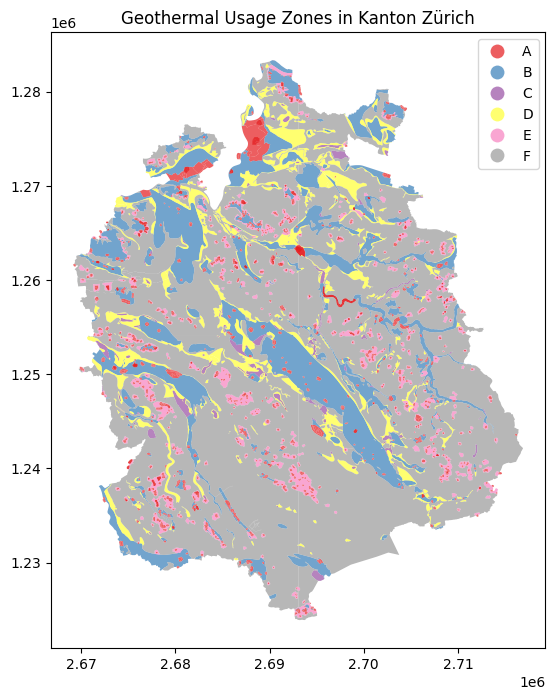

In [9]:
# Plot the dataset
fig, ax = plt.subplots(figsize=(10, 8))
zh_waermenutzung_gdf.plot(ax=ax, column="ZONEN", cmap="Set1", legend=True, edgecolor=None, alpha=0.7)

# Add title
ax.set_title("Geothermal Usage Zones in Kanton Zürich")

# Show plot
plt.show()

The original dataset contains multiple layers and categories regarding various thermal energy extraction methods, such as groundwater heating and energy registers. However, for our specific analysis, which centers on **geothermal probes**, these additional categories introduce unnecessary complexity that can be simplified with fewer zone classifications.

The following plot focuses on the `restrictions` variable we have defined previously, in order to achieve the simplification. By filtering the dataset to display only the **restrictions for geothermal probes**, we created a more **clear and interpretable visualization**. The new color scheme, **green for allowed areas, orange for conditional approvals, and red for restricted zones**, ensures an intuitive understanding of where geothermal probes can be installed in the Zürich region.

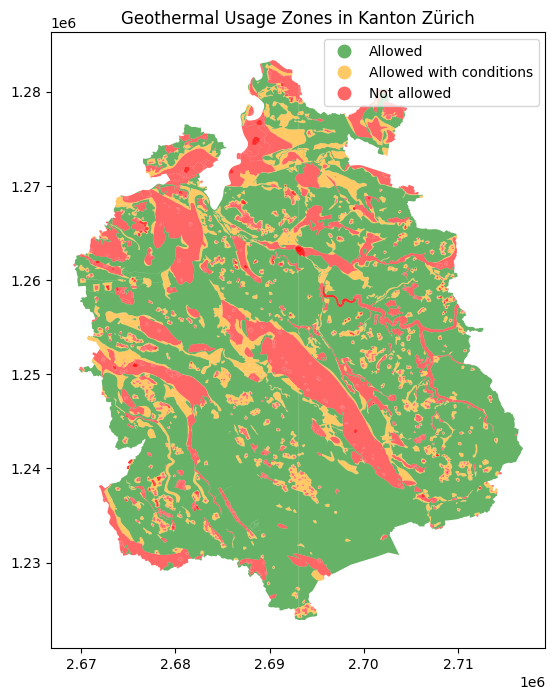

In [10]:
# Define the custom color mapping
cmap = mcolors.ListedColormap(["green", "orange", "red"])  # Not allowed, conditions, allowed
categories = [ "Allowed", "Allowed with conditions", "Not allowed",]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
zh_waermenutzung_gdf.plot(
    ax=ax, column="restrictions", cmap=cmap, legend=True, edgecolor=None, alpha=0.6
)

# Modify legend labels
leg = ax.get_legend()
for i, text in enumerate(leg.get_texts()):
    text.set_text(categories[i])

# Add title
ax.set_title("Geothermal Usage Zones in Kanton Zürich")

# Show plot
plt.show()

An alpha factor has been deliberately added to the plot to show that **some areas appear to have overlapping polygons**, since there is a hierarchical structure to the different restriction classifications, creating unintended visual artifacts. This is due to the dataset containing **multiple layers of polygons that are not merged**, meaning that areas with the same restriction category (e.g., "Not allowed") were fragmented instead of being represented as a single, unified region. This overlap made it difficult to **interpret the spatial distribution of geothermal restrictions clearly** and could lead to misinterpretations in analysis.

To fix this, we use the **`.dissolve(by="restrictions")`** function to merge all polygons that share the same restriction category into a single geometry. However, this initially caused a **TopologyException** due to invalid geometries in the dataset. The issue was resolved by applying `.buffer(0)`, a common trick to clean self-intersecting or overlapping geometries without altering their spatial integrity. This allowed us to successfully merge the regions, resulting in a cleaner, more readable visualization where each restriction category is properly displayed as a single, unified area.

We also drop the `ZONEN` column, as it becomes irrelevant for the simple evaluation of whether a location is valid or not for a geothermal probe having the more descriptive `restrictions` value.

In [11]:
# Create a copy to preserve the original dataset
zh_waermenutzung_gdf_merged = zh_waermenutzung_gdf.copy()

# Ensure geometries are valid (fix invalid ones)
zh_waermenutzung_gdf_merged["geometry"] = zh_waermenutzung_gdf_merged["geometry"].buffer(0)

# Dissolve polygons by the 'restrictions' column
zh_waermenutzung_gdf_merged = zh_waermenutzung_gdf_merged.dissolve(by="restrictions")

# Reset index to avoid issues when plotting
zh_waermenutzung_gdf_merged = zh_waermenutzung_gdf_merged.reset_index()

# Drop the 'ZONEN' column as it is no longer needed
zh_waermenutzung_gdf_merged = zh_waermenutzung_gdf_merged.drop(columns=["ZONEN"], errors="ignore")

# Reorder the columns
column_order = ["gml_id", "restrictions", "geometry"]
zh_waermenutzung_gdf_merged = zh_waermenutzung_gdf_merged[column_order]

# Display the updated dataframe
zh_waermenutzung_gdf_merged.head()

,gml_id,restrictions,geometry
0,waermenutzung-zone-f.228054,Allowed,"MULTIPOLYGON (((2674276.084 1231131.478, 26742..."
1,waermenutzung-zone-c.227329,Allowed with conditions,"MULTIPOLYGON (((2675512.502 1232303.526, 26755..."
2,waermenutzung-zone-a.1,Not allowed,"MULTIPOLYGON (((2672375.371 1236768.951, 26723..."


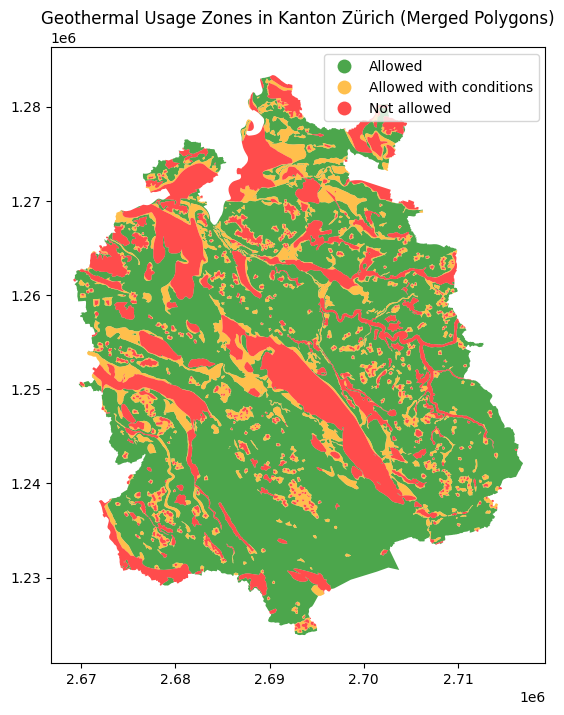

In [12]:
# Define the custom color mapping
cmap = mcolors.ListedColormap(["green", "orange", "red"])  # Allowed, conditions, not allowed
categories = ["Allowed", "Allowed with conditions", "Not allowed"]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
zh_waermenutzung_gdf_merged.plot(
    ax=ax, column="restrictions", cmap=cmap, legend=True, edgecolor=None, alpha=0.7
)

# Modify legend labels
leg = ax.get_legend()
for i, text in enumerate(leg.get_texts()):
    text.set_text(categories[i])

# Add title
ax.set_title("Geothermal Usage Zones in Kanton Zürich (Merged Polygons)")

# Show plot
plt.show()

---

### 2.2. Geothermal Probe Restrictions (Erdwärmesonden Auflagen)

The `zonen` attribute in this dataset categorizes areas based on **usage restrictions** for the construction of geothermal probes:

- **Auflagen**: Areas where geothermal probes are permitted but subject to specific conditions, detailed in the `BEMERKUNG` field.
- **Verbot**: Areas where geothermal probes are strictly prohibited, with explanations provided in the `BEMERKUNG` field.

This classification is done based on an integration of geological and zoning models developed by the **Baudirektion** of the canton of Zürich, and establishes different levels of allowability based on the depth of specific underground rock layers, which are crucial to the protection of water reservoirs.

This is documented in AWEL's (Amt für Abfall, Wasser, Energie und Luft) [Depth restriction of geothermal probes for protection of rock aquifers Upper Marine Molasse and Malm (mineral water deposits)](https://www.zh.ch/content/dam/zhweb/bilder-dokumente/themen/planen-bauen/bauvorschriften/energienutzung-aus-untergrund-und-wasser/mehr-zum-thema/tiefenbeschraenkung_ews.pdf), which provides an overview of the geological and hydrogeological constraints that determine the maximum permissible drilling depths for geothermal probes in the Canton of Zurich. These depth restrictions are primarily based on deep geological formations that impact groundwater flow and thermal conductivity.

**Summary of the Depth Restrictions due to Geological Factors:**
- The primary limitation comes from the **Malm layer**, which is found at an approximate depth of **400 meters** across most of the canton.
- Two main geological datasets are used to define these restrictions:
  - **Geological Atlas of Switzerland** and borehole archives from various geological institutions.
  - **Hydrogeological studies** conducted in northern Zurich to assess groundwater conditions.
- The **depth limitations are stricter** in areas classified as "Verbot" (prohibited zones) or "Auflagen" (restricted zones with conditions).
- In unrestricted areas, the **maximum permitted depth is generally 400 meters**, aligning with the Malm layer's depth.

The document serves as the **foundation for depth regulations in Zurich’s geothermal energy policies**, ensuring that boreholes do not interfere with critical groundwater formations. In areas where drilling is permitted, **depth limitations may apply**, based on a model that is currently **not accessible via the GIS portal**. However, the **maximum allowable depth can be visualized graphically within the GIS system**.  

As of the time of writing this dissertation, the **Wärmenutzungsatlas is undergoing reconstruction**, with plans to integrate this depth regulation data into its open datasets. This update is expected to be available by **2026**. A currently functioning method of obtaining the maximum permitted depth will nonetheless be assessed later on in this notebook.

In [13]:
zh_restrictions_gdf = gpd.read_file("data/raw/zh_erdwaermesonden_auflagen.geojson")

print("\nRestrictions (Auflagen):")
zh_restrictions_gdf.head()


Restrictions (Auflagen):


,gml_id,zonen,geometry
0,erdwaermesonden-auflagen.107,Verbot,"POLYGON ((2678786.488 1249290.376, 2678785.911..."
1,erdwaermesonden-auflagen.108,Verbot,"POLYGON ((2679379.648 1248504.431, 2679379.044..."
2,erdwaermesonden-auflagen.109,Auflagen,"POLYGON ((2682120.057 1243256.662, 2682110.162..."
3,erdwaermesonden-auflagen.110,Auflagen,"POLYGON ((2699212.881 1268866.187, 2699212.924..."
4,erdwaermesonden-auflagen.111,Auflagen,"MULTIPOLYGON (((2679461.435 1247400.626, 26794..."


In [14]:
print("\nUnique ZONEN values in Restrictions:", zh_restrictions_gdf["zonen"].unique())


Unique ZONEN values in Restrictions: ['Verbot' 'Auflagen']


As previously explained, the interpretation of **prohibited** and **restricted zones** follows the same approach as in the ground heat usage dataset, given that both pertain to geothermal probes. However, the **restrictions** dataset imposes stricter limitations, which take precedence over the initial zoning classifications. To ensure consistency and streamline the merging process, we will adopt the same naming conventions for columns and categorical values across both datasets.

In [15]:
# Rename the column "zonen" to "restrictions"
zh_restrictions_gdf = zh_restrictions_gdf.rename(columns={"zonen": "restrictions"})

# Map the categorical values to match the first dataset
zh_restrictions_gdf["restrictions"] = zh_restrictions_gdf["restrictions"].map({
    "Verbot": "Not allowed",
    "Auflagen": "Allowed with conditions"
})

# Display the updated dataframe
zh_restrictions_gdf.head()

,gml_id,restrictions,geometry
0,erdwaermesonden-auflagen.107,Not allowed,"POLYGON ((2678786.488 1249290.376, 2678785.911..."
1,erdwaermesonden-auflagen.108,Not allowed,"POLYGON ((2679379.648 1248504.431, 2679379.044..."
2,erdwaermesonden-auflagen.109,Allowed with conditions,"POLYGON ((2682120.057 1243256.662, 2682110.162..."
3,erdwaermesonden-auflagen.110,Allowed with conditions,"POLYGON ((2699212.881 1268866.187, 2699212.924..."
4,erdwaermesonden-auflagen.111,Allowed with conditions,"MULTIPOLYGON (((2679461.435 1247400.626, 26794..."


A visualization of this dataset poses the question of whether there is an overlay with the first one, in terms of what areas are not allowed for geothermal probes.

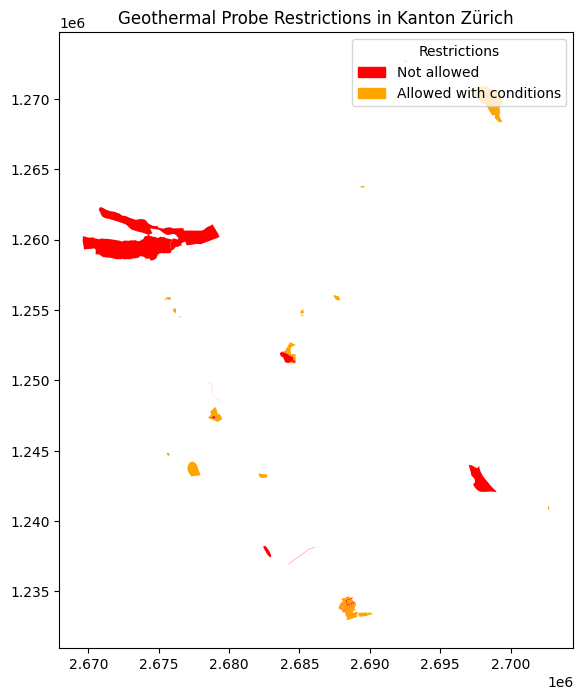

In [16]:
# Define color mapping for restrictions
color_mapping = {
    "Not allowed": "red",
    "Allowed with conditions": "orange"
}

# Map colors based on restriction categories
colors = zh_restrictions_gdf["restrictions"].map(color_mapping)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
zh_restrictions_gdf.plot(ax=ax, color=colors, edgecolor=None, alpha=1)

# Manually create a legend
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_mapping.items()]
ax.legend(handles=legend_patches, title="Restrictions", loc="upper right")

# Add title
ax.set_title("Geothermal Probe Restrictions in Kanton Zürich")

# Show plot
plt.show()

---

### 2.3. Merging the Ground Heat Zones with the Restrictions Datasets

We now merge both datasets to retain the information which can be interpreted equally across both.

In [17]:
# Merge the two datasets
zh_combined_gdf = gpd.pd.concat([zh_waermenutzung_gdf_merged, zh_restrictions_gdf], ignore_index=True)

# Ensure geometries are valid
zh_combined_gdf["geometry"] = zh_combined_gdf["geometry"].buffer(0)

# Dissolve overlapping polygons by 'restrictions' to remove overlaps
zh_combined_gdf = zh_combined_gdf.dissolve(by="restrictions")

# Reset index to keep a clean dataframe
zh_combined_gdf = zh_combined_gdf.reset_index()

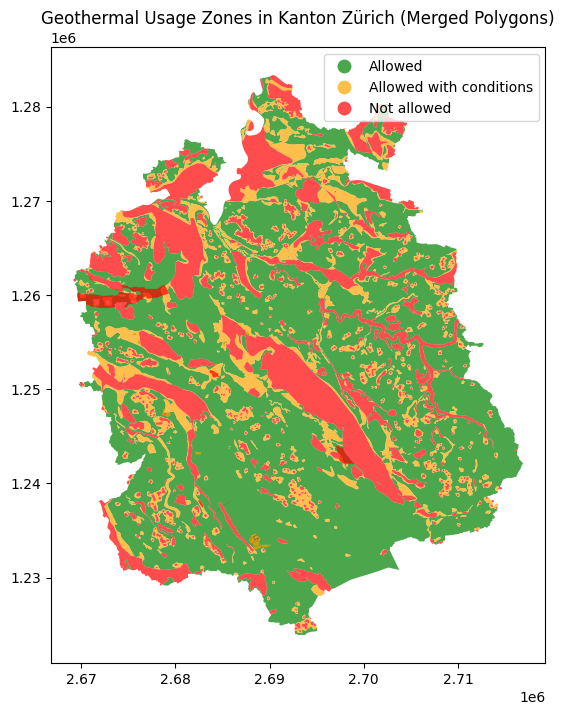

In [18]:
# Define the custom color mapping
cmap = mcolors.ListedColormap(["green", "orange", "red"])  # Allowed, conditions, not allowed
categories = ["Allowed", "Allowed with conditions", "Not allowed"]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
zh_combined_gdf.plot(
    ax=ax, column="restrictions", cmap=cmap, legend=True, edgecolor=None, alpha=.7
)

# Modify legend labels
leg = ax.get_legend()
for i, text in enumerate(leg.get_texts()):
    text.set_text(categories[i])

# Add title
ax.set_title("Geothermal Usage Zones in Kanton Zürich (Merged Polygons)")

# Show plot
plt.show()

To ensure that each geographic location in the dataset has a **unique classification** (either "Allowed", "Allowed with conditions", or "Not allowed"), we perform **boolean spatial operations** to remove overlapping areas. The hierarchy follows a strict rule: **"Not allowed" > "Allowed with conditions" > "Allowed"**, meaning if an area falls under multiple categories, the most restrictive classification takes precedence. Using **geospatial overlay operations**, we subtract the "Not allowed" areas from both "Restricted" and "Allowed" zones, ensuring that these regions are removed from less restrictive classifications. Then, we further refine the "Allowed" areas by subtracting the "Restricted" ones, preventing overlaps. This process ensures that any point queried within the dataset will return a single, **unambiguous** classification, making the dataset suitable for **geothermal probe feasibility assessments**.

In [23]:
# Ensure geometries are valid
print("\n🔍 Validating geometries...")
zh_combined_gdf["geometry"] = zh_combined_gdf["geometry"].buffer(0)
print("✅ Geometries validated.\n")

# Separate layers
print("🔹 Step 1: Separating layers...")
not_allowed = zh_combined_gdf[zh_combined_gdf["restrictions"] == "Not allowed"]
restricted = zh_combined_gdf[zh_combined_gdf["restrictions"] == "Allowed with conditions"]
allowed = zh_combined_gdf[zh_combined_gdf["restrictions"] == "Allowed"]
print(f"   ➝ Not allowed: {len(not_allowed)} polygons")
print(f"   ➝ Restricted: {len(restricted)} polygons")
print(f"   ➝ Allowed: {len(allowed)} polygons\n")

# Subtract "Not allowed" from both other categories
print("🛠  Step 2: Removing 'Not allowed' areas from 'Restricted'...")
restricted = overlay(restricted, not_allowed, how="difference")
print(f"   ✅ Completed! Remaining restricted areas: {len(restricted)} polygons\n")

print("🛠  Step 3: Removing 'Not allowed' areas from 'Allowed'...")
allowed = overlay(allowed, not_allowed, how="difference")
print(f"   ✅ Completed! Remaining allowed areas: {len(allowed)} polygons\n")

# Subtract "Restricted" from "Allowed"
print("🛠  Step 4: Removing 'Restricted' areas from 'Allowed'...")
allowed = overlay(allowed, restricted, how="difference")
print(f"   ✅ Completed! Remaining allowed areas: {len(allowed)} polygons\n")

# Merge back into a single dataset
print("🔄 Step 5: Merging cleaned layers into final dataset...")
zh_cleaned_gdf = pd.concat([not_allowed, restricted, allowed], ignore_index=True)
print(f"   ✅ Merged dataset contains: {len(zh_cleaned_gdf)} polygons\n")

# Remove empty geometries
print("🧹 Removing empty geometries...")
zh_cleaned_gdf = zh_cleaned_gdf[~zh_cleaned_gdf.geometry.is_empty]
print(f"   ✅ Cleaned dataset contains: {len(zh_cleaned_gdf)} polygons\n")

# Reset index
zh_cleaned_gdf = zh_cleaned_gdf.reset_index(drop=True)

# Drop 'gml_id' column
if "gml_id" in zh_cleaned_gdf.columns:
    print("🗑️ Dropping 'gml_id' column...")
    zh_cleaned_gdf = zh_cleaned_gdf.drop(columns=["gml_id"])
    print("   ✅ Column dropped.\n")

# Save the dataset
output_merged_geojson = "data/transformed/zh_combined_restrictions.geojson"
print("💾 Saving the final cleaned dataset...")
zh_cleaned_gdf.to_file(output_merged_geojson, driver="GeoJSON")
print(f"✅ Restrictions saved as: {output_merged_geojson}\n")

# Display first few rows
zh_cleaned_gdf.head()


🔍 Validating geometries...
✅ Geometries validated.

🔹 Step 1: Separating layers...
   ➝ Not allowed: 1 polygons
   ➝ Restricted: 1 polygons
   ➝ Allowed: 1 polygons

🛠  Step 2: Removing 'Not allowed' areas from 'Restricted'...


C:\Users\leina\AppData\Local\Temp\ipykernel_23248\2824749135.py:17: UserWarning:

`keep_geom_type=True` in overlay resulted in 900 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries



   ✅ Completed! Remaining restricted areas: 1 polygons

🛠  Step 3: Removing 'Not allowed' areas from 'Allowed'...
   ✅ Completed! Remaining allowed areas: 1 polygons

🛠  Step 4: Removing 'Restricted' areas from 'Allowed'...
   ✅ Completed! Remaining allowed areas: 1 polygons

🔄 Step 5: Merging cleaned layers into final dataset...
   ✅ Merged dataset contains: 3 polygons

🧹 Removing empty geometries...
   ✅ Cleaned dataset contains: 3 polygons

🗑️ Dropping 'gml_id' column...
   ✅ Column dropped.

💾 Saving the final cleaned dataset...
✅ Restrictions saved as: data/transformed/zh_combined_restrictions.geojson



,restrictions,geometry
0,Not allowed,"MULTIPOLYGON (((2716091.516 1243493.144, 27160..."
1,Allowed with conditions,"MULTIPOLYGON (((2675449.435 1232309.951, 26754..."
2,Allowed,"MULTIPOLYGON (((2671795.508 1253960.555, 26718..."


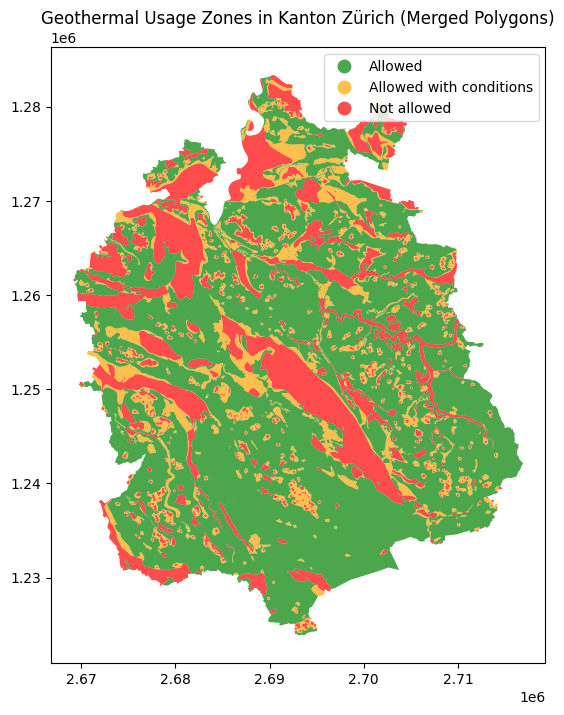

In [24]:
# Define the custom color mapping
cmap = mcolors.ListedColormap(["green", "orange", "red"])  # Allowed, conditions, not allowed
categories = ["Allowed", "Allowed with conditions", "Not allowed"]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 8))
zh_cleaned_gdf.plot(
    ax=ax, column="restrictions", cmap=cmap, legend=True, edgecolor=None, alpha=.7
)

# Modify legend labels
leg = ax.get_legend()
for i, text in enumerate(leg.get_texts()):
    text.set_text(categories[i])

# Add title
ax.set_title("Geothermal Usage Zones in Kanton Zürich (Merged Polygons)")

# Show plot
plt.show()

---

## 3. Querying Geothermal Probe Allowance Based on Location

To enable a seamless querying mechanism for determining the allowance status of a given location, we introduce a function that performs spatial queries on the processed dataset. The ultimate goal is to integrate this functionality into a UI-based application featuring an interactive map widget. 

Since standard map tile providers operate in **WGS84 coordinates**, while Swiss geospatial datasets maintain higher accuracy in **LV95 (Swiss Coordinate System)**, we preserve all datasets in LV95 for compatibility with other Swiss geodata. However, user inputs will be provided in WGS84 and must be converted accordingly before performing spatial operations.

This function takes **WGS84 coordinates as input**, converts them to LV95, and checks their intersection with the preprocessed restriction polygons. If a match is found, it returns the corresponding restriction category as a string. By encapsulating this logic into a function, we ensure flexibility for integrating the mechanism into various applications, including batch processing of multiple points.


In [8]:
# !pip install jupyterlab-widgets ipywidgets

In [34]:
import ipyleaflet
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point
import ipywidgets as widgets

In [5]:
# Load the cleaned dataset
zh_cleaned_gdf = gpd.read_file("data/transformed/zh_combined_restrictions.geojson")

# Ensure the dataset is in LV95 (Swiss Coordinate System)
zh_cleaned_gdf = zh_cleaned_gdf.to_crs("EPSG:2056")

# Print CRS (coordinate system)
print(f"🗺️ Coordinate System: {zh_cleaned_gdf.crs}")

🗺️ Coordinate System: EPSG:2056


In [6]:
# Define a function to check restrictions for a given coordinate
def check_restriction(lat, lon):
    """Takes WGS84 latitude & longitude and returns the restriction status."""
    
    # Convert user coordinates from WGS84 to LV95
    wgs84_to_lv95 = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:2056", always_xy=True)
    lv95_x, lv95_y = wgs84_to_lv95.transform(lon, lat)
    
    # Create a point in LV95
    user_point_lv95 = Point(lv95_x, lv95_y)

    # Check if the point falls within any restriction area
    matching_row = zh_cleaned_gdf[zh_cleaned_gdf.contains(user_point_lv95)]

    if not matching_row.empty:
        restriction_value = matching_row.iloc[0]["restrictions"]
        return f"✅ The location ({lat}, {lon}) falls within a '{restriction_value}' zone."
    else:
        return f"❌ The location ({lat}, {lon}) is not within any restriction zone."

In [7]:
# Example usage with multiple test points
test_points = [
    (47.3769, 8.5417),  # Example: Zürich city center
    (47.4000, 8.5500),  # Example: Another Zürich location
    (47.3500, 8.6000)   # Example: Outside urban Zürich
]

# Run the function on multiple points
for lat, lon in test_points:
    print(check_restriction(lat, lon))

✅ The location (47.3769, 8.5417) falls within a 'Not allowed' zone.
✅ The location (47.4, 8.55) falls within a 'Allowed' zone.
✅ The location (47.35, 8.6) falls within a 'Allowed' zone.


---

### 3.1. Implementing a Map Widget

In [46]:
# Load the Zürich boundary GeoJSON
boundary_gdf = gpd.read_file("data/raw/zh_boundary.geojson")
boundary_geojson = json.loads(boundary_gdf.to_json())  # Convert to JSON format

# Initialize ipyleaflet map centered on Zürich
m = ipyleaflet.Map(center=(47.3769, 8.5417), zoom=10)

# Create a GeoJSON layer for the boundary
boundary_layer = ipyleaflet.GeoJSON(
    data=boundary_geojson,
    style={"color": "gray", "fillOpacity": 0.2},  # Boundary style
    name="Zürich Boundary"
)

# Add the boundary layer to the map
m.add_layer(boundary_layer)

# Create an output widget
output = widgets.Output()

# Create a draggable marker
marker = ipyleaflet.Marker(location=(47.3769, 8.5417), draggable=True)
m.add_layer(marker)

# Define function for coordinate conversion & restriction query
def check_restriction(lat, lon):
    """Takes WGS84 latitude & longitude and returns the restriction status."""
    
    # Convert user coordinates from WGS84 to LV95
    wgs84_to_lv95 = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:2056", always_xy=True)
    lv95_x, lv95_y = wgs84_to_lv95.transform(lon, lat)
    
    # Create a point in LV95
    user_point_lv95 = Point(lv95_x, lv95_y)

    # Check if the point falls within any restriction area
    matching_row = zh_cleaned_gdf[zh_cleaned_gdf.contains(user_point_lv95)]

    if not matching_row.empty:
        return matching_row.iloc[0]["restrictions"]
    else:
        return "❌ Outside of Canton Limits!"

# Function to handle marker drag event
def on_marker_drag(change):
    """Triggered when marker is dragged to a new location."""
    lat, lon = marker.location  # Get new marker location
    
    # Query restriction status
    restriction_value = check_restriction(lat, lon)
    
    # Display result
    with output:
        output.clear_output()
        print(f"📍 Dragged to: ({lat:.5f}, {lon:.5f}) → Status: {restriction_value}")

# Attach event listener for dragging
marker.observe(on_marker_drag, "location")

# Display map and output
display(m, output)

Map(center=[47.3769, 8.5417], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…

Output()